#### 姓名：崔佳音
#### 学号：22210980003

1.目标：使用numpy构建两层神经网络分类器，对MiNIST数据集进行训练与测试。<br>
2.实现步骤：<br>
(1) 数据预处理：分为train训练、valid验证、test测试三个数据集。<br>
(2) 定义激活函数，tanh、softmax<br>
(3) 定义层数以及每层参数<br>
(4) 初始化参数<br>
(5) 定义预测函数<br>
(6) 定义损失函数 <br>
(7) 反向传播求导数<br>
(8) 梯度下降更新参数<br>
(9) 训练<br>
(10) 可视化训练和测试的loss曲线，测试的accuracy曲线<br>
(11) 可视化每层的网络参数<br>

github repo链接:<br>
https://github.com/Holly134340/2023-Neural_Network--/tree/main

详细过程及代码如下：

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from keras.datasets import mnist

In [127]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 数据预处理
train_num = 50000
valid_num = 10000
test_num = 10000
#保证数据取值在(0,1)之间,同时将训练集的后10000数据取出作为验证集，保留所有数据为矩阵形式
X_train = X_train.reshape(X_train.shape[0], -1).T / 255.
X_test = X_test.reshape(X_test.shape[0], -1).T / 255.

y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)

X_valid = X_train[:,50000:60000]
y_valid = y_train[:,50000:60000]

X_train = X_train[:,:50000]
y_train = y_train[:,:50000]



In [128]:
#定义两层激活函数，分别为：tanh、softmax

def tanh(x):
    return np.tanh(x)

def softmax(x):
    exp = np.exp(x-x.max())
    return exp/exp.sum()

In [129]:
#定义输入与输出的纬度，即输入为28*28，输出为0~9，共10个数字
dimensions = [28*28,10]
#定义激活函数activation，含有上述定义的tanh与softmax函数
activation = [tanh,softmax]
#定义参数，注：第一层为‘data+b’形式，即只有一个参数b，第二层为“wx+b”形式，有两个参数：w与b，并定义其范围，存入distribution中
distribution = [
    {'b':[0,0]},
    {'b':[0,0],'w':[-math.sqrt(6/(dimensions[0]+dimensions[1])), math.sqrt(6/(dimensions[0]+dimensions[1]))]}
]

In [130]:
#定义函数，用于根据上述定义参数范围初始化参数

def init_parameters_b(layer):
    dist = distribution[layer]['b']
    return np.random.rand(dimensions[layer])*(dist[1]-dist[0])+dist[0]

def init_parameters_w(layer):
    dist = distribution[layer]['w']
    return np.random.rand(dimensions[layer-1],dimensions[layer])*(dist[1]-dist[0])+dist[0]

def init_parameters():
    parameter = []
    for i in range(len(distribution)):
        layer_parameter = {}
        for j in distribution[i].keys():
            if j == 'b':
                layer_parameter['b'] = init_parameters_b(i)
                continue
            if j == 'w':
                layer_parameter['w'] = init_parameters_w(i)
                continue
        parameter.append(layer_parameter)
        
    return parameter

In [131]:
#检验初始化参数形式是否正确，并展示parameters的结构
parameters = init_parameters()

In [132]:
#定义预测函数，输入为img(即28*28=784的数据，与对应参数)，输出为预测属于每一个分类的概率

def predict(img,parameters):
    l0_in = img+parameters[0]['b']
    l0_out = activation[0](l0_in)
    l1_in = np.dot(l0_out,parameters[1]['w'])+parameters[1]['b']
    l1_out = activation[1](l1_in)
    return l1_out

In [133]:
#测试predict函数
predict(np.random.rand(784),parameters).argmax()

2

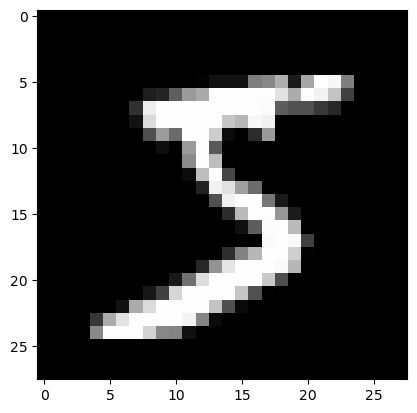

In [134]:
#将图片绘制出来

im = np.reshape(X_train[:,0],(28,28))
plt.imshow(im,cmap = 'gray')

In [135]:
#定义激活函数的导数，并将其写入differential中
def d_softmax(data):
    sm = softmax(data)
    return np.diag(sm)-np.outer(sm,sm)
def d_tanh(data):
    return 1/np.cosh(data)**2

differential = {softmax:d_softmax,tanh:d_tanh}

In [136]:
#onthot用于将lab变成向量形式
onehot = np.identity(dimensions[-1])

In [137]:
#定义损失函数
def sqr_loss(img,lab,parameters):
    y_pred = predict(img, parameters)
    y = onehot[lab]
    diff = y-y_pred
    return np.dot(diff,diff)

In [138]:
#定义函数，用于得到损失函数对于每一个参数的导数，即梯度
def grad_parameters(img,lab,parameters):
    l0_in = img+parameters[0]['b']
    l0_out = activation[0](l0_in)
    l1_in = np.dot(l0_out,parameters[1]['w'])+parameters[1]['b']
    l1_out = activation[1](l1_in)
    
    diff = onehot[lab]-l1_out
    act1 = np.dot(differential[activation[1]](l1_in),diff)

    grad_b1 = -2*act1
    grad_w1 = -2*np.outer(l0_out,act1)
    grad_b0 = -2*differential[activation[0]](l0_in)*np.dot(parameters[1]['w'],act1)
    
    return {'w1':grad_w1,'b1':grad_b1,'b0':grad_b0}

In [139]:
#h1,验证b1求导是否正确
h = 0.0001
train_num = 50000
for i in range(10):
    img_i = np.random.randint(train_num)
    test_parameters = init_parameters()
    derivative = grad_parameters(X_train[:,img_i],y_train[0,img_i],test_parameters)['b1']
    value1 = sqr_loss(X_train[:,img_i],y_train[0,img_i],test_parameters)
    test_parameters[1]['b'][i]+=h
    value2 = sqr_loss(X_train[:,img_i],y_train[0,img_i],test_parameters)
    print(derivative[i]-(value2-value1)/h)

-5.842837411812463e-10
-1.1844529095202116e-06
-5.189680620304102e-07
6.557840532217529e-06
-1.598007918298186e-06
-1.715083529984368e-06
-2.1529596478837842e-06
-4.57100478426075e-07
-2.9172552317296985e-06
-1.9025966167610098e-06


In [140]:
#验证w1求导是否正确
h = 0.0001
train_num = 50000
grad_list = []
for i in range(784):
    for j in range(10):
        
        img_i = np.random.randint(train_num)
        test_parameters = init_parameters()
        derivative = grad_parameters(X_train[:,img_i],y_train[0,img_i],test_parameters)['w1']
        value1 = sqr_loss(X_train[:,img_i],y_train[0,img_i],test_parameters)
        test_parameters[1]['w'][i][j]+=h
        value2 = sqr_loss(X_train[:,img_i],y_train[0,img_i],test_parameters)
        grad_list.append(derivative[i][j]-(value2-value1)/h)

np.abs(grad_list).max()

4.165136314598916e-06

In [141]:
#验证b0求导是否正确
h = 0.000001
train_num = 50000
grad_list = []
for i in range(784):
    img_i = np.random.randint(train_num)
    test_parameters = init_parameters()
    derivative = grad_parameters(X_train[:,img_i],y_train[0,img_i],test_parameters)['b0']
    value1 = sqr_loss(X_train[:,img_i],y_train[0,img_i],test_parameters)
    test_parameters[0]['b'][i]+=h
    value2 = sqr_loss(X_train[:,img_i],y_train[0,img_i],test_parameters)
    grad_list.append(derivative[i]-(value2-value1)/h)

np.abs(grad_list).max()

8.971326941747959e-09

In [142]:
#将valid集中的loss累加
def valid_loss(parameters):
    loss_accu = 0
    for img_i in range(valid_num):
        loss_accu+=sqr_loss(X_valid[:,img_i], y_valid[0,img_i],parameters)
    return loss_accu/(valid_num/10000)
#定义函数，计算验证集准确率
def valid_accuracy(parameters):
    correct = [predict(X_valid[:,img_i],parameters).argmax()==y_valid[0,img_i] for img_i in range(valid_num)]
    return correct.count(True)/len(correct)
#定义函数，得到训练集loss    
def train_loss(parameters):
    loss_accu = 0
    for img_i in range(train_num):
        loss_accu+=sqr_loss(X_train[:,img_i], y_train[0,img_i],parameters)
    return loss_accu/(train_num/10000)
#定义函数，得到训练集准确率
def train_accuracy(parameters):
    correct = [predict(X_train[:,img_i],parameters).argmax()==y_train[0,img_i] for img_i in range(train_num)]
    return correct.count(True)/len(correct)

In [143]:
#用初始参数进行测试，即随机分类
valid_accuracy(init_parameters())

0.12

In [144]:
#定义函数，将数据进行分组，并得到每一组的梯度平均值
batch_size=100
def train_batch(current_batch, parameters):
    grad_accu = grad_parameters(X_train[:,current_batch*batch_size+0],y_train[0,current_batch*batch_size+0],parameters)
    for img_i in range(1,batch_size):
        grad_tmp = grad_parameters(X_train[:,current_batch*batch_size+img_i],y_train[0,current_batch*batch_size+img_i],parameters)
        for key in grad_accu.keys():
            grad_accu[key]+=grad_tmp[key]
    for key in grad_accu.keys():
            grad_accu[key]/=batch_size      
    return grad_accu

In [145]:
import copy
#使用梯度下降法，更新参数
def combine_parameters(parameters, grad, learn_rate):
    parameter_tmp = copy.deepcopy(parameters)
    parameter_tmp[0]['b']-=learn_rate*grad['b0']
    parameter_tmp[1]['b']-=learn_rate*grad['b1']
    parameter_tmp[1]['w']-=learn_rate*grad['w1']
    return parameter_tmp

In [146]:
parameters = init_parameters()
current_epoch = 0
train_loss_list = []
valid_loss_list = []
train_accu_list = []
valid_accu_list = []

In [147]:
valid_accuracy(parameters)

0.111

In [148]:
from tqdm import tqdm

In [149]:
#进行训练
learn_rate = 10**-0.5
epoch_num = 10
for epoch in tqdm(range(epoch_num)):
    for i in range(train_num//batch_size):
        grad_tmp = train_batch(i,parameters)
        parameters = combine_parameters(parameters, grad_tmp, learn_rate)
    current_epoch += 1
    train_loss_list.append(train_loss(parameters))
    valid_loss_list.append(valid_loss(parameters))
    train_accu_list.append(train_accuracy(parameters))
    valid_accu_list.append(valid_accuracy(parameters))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:05<00:00, 18.53s/it]


In [150]:
#验证集准确率
valid_accuracy(parameters)

0.9274

In [151]:
#测试集准确率
train_accuracy(parameters)

0.9255

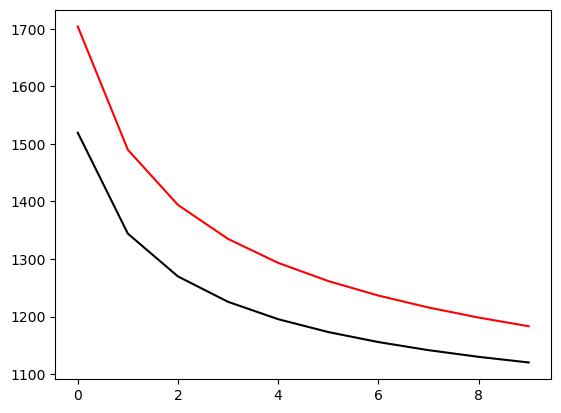

In [152]:
#绘制loss变化图像
lower = 0
plt.plot(valid_loss_list[lower:],color = 'black',label = 'validation loss')
plt.plot(train_loss_list[lower:],color = 'red',label = 'train loss')
plt.show()

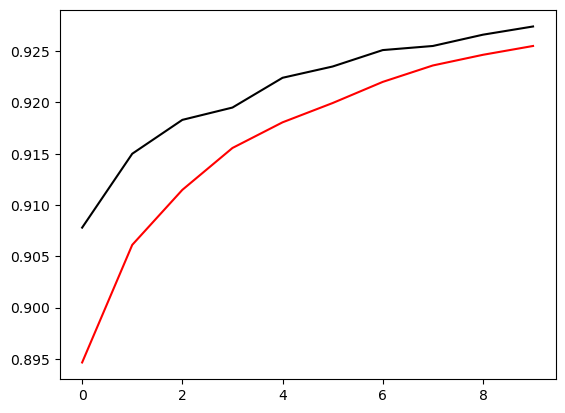

In [153]:
#绘制准确率变化图像
plt.plot(valid_accu_list[lower:],color = 'black',label = 'validation accurancy')
plt.plot(train_accu_list[lower:],color = 'red',label = 'train accurancy')
plt.show()

In [154]:
#寻找最优学习率
rand_batch = np.random.randint(train_num/batch_size)
grad_lr = train_batch(rand_batch, parameters)

In [155]:
lr_list = []
lower = -2
upper = 0
step = 0.1
for lr_pow in tqdm(np.linspace(lower, upper, num = int((upper-lower)//step+1))):
    learn_rate = 10**lr_pow
    parameters_tmp = combine_parameters(parameters,grad_lr,learn_rate)
    train_loss_tmp = train_loss(parameters_tmp)
    lr_list.append([lr_pow,train_loss_tmp])

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:04<00:00,  3.22s/it]


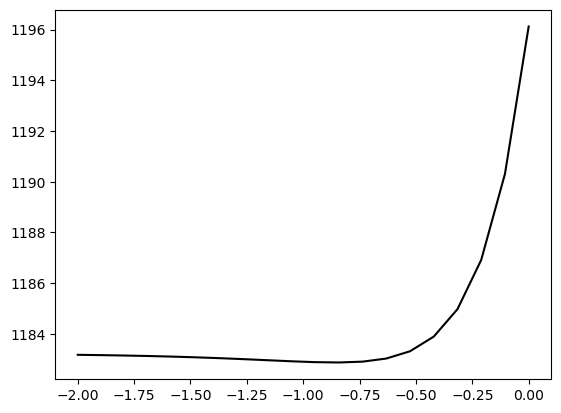

In [156]:
plt.plot(np.array(lr_list)[:,0],np.array(lr_list)[:,1],color = 'black')
plt.show()

In [157]:
#用测试集进行测试，并得到准确率
def test_accuracy(parameters):
    correct = [predict(X_test[:,img_i],parameters).argmax()==y_test[0,img_i] for img_i in range(test_num)]
    return correct.count(True)/len(correct)


In [158]:
print('测试集的准确率为：{}'.format(test_accuracy(parameters)))

测试集的准确率为：0.9256


In [166]:
#可视化参数
#第一层
print('b0: {}'.format(parameters[0]['b']))
#第二层
print('b1: {}\nw1: {}'.format(parameters[1]['b'],parameters[1]['w']))

b0: [ 1.85467756e-02  1.20848461e-02 -5.89682185e-03 -1.77929654e-02
  2.93850760e-02  6.38363498e-03 -3.04126167e-02 -1.09197033e-02
 -1.37084914e-02 -2.29068333e-02  1.81305127e-02 -3.51070225e-03
  2.73471412e-03 -2.39784994e-02 -6.97863648e-03 -7.18629664e-04
 -1.36522470e-02  2.67468737e-02 -2.81826734e-02 -1.76004213e-03
 -6.55428634e-03  1.30254511e-02  3.19261086e-03 -1.67200021e-02
 -1.26377865e-02 -1.97850434e-02  1.54736115e-02  1.24135777e-02
  2.42569936e-02 -2.85977359e-02  6.94091039e-03 -6.75947729e-03
  3.33526900e-03  4.11132832e-03 -5.08219686e-03 -1.23147176e-02
 -1.10085887e-02 -3.53242809e-02  1.58062371e-02  1.24117259e-02
 -3.51662735e-02  4.04408227e-03  6.37740832e-03  4.31093157e-03
 -2.00660388e-02 -7.22031526e-03  1.16754585e-02 -7.41897664e-03
 -2.46653233e-02  1.35810376e-02  1.34535295e-02  2.54495830e-03
  3.13851858e-02  7.78275417e-03 -1.55709443e-02  2.12434981e-02
  3.06801944e-05  2.03932823e-04 -5.10431211e-03 -7.78628345e-03
 -6.08577602e-03 -1.1